In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import category_encoders as ce
import time

# Prep for Modeling

In [2]:
DF = pd.read_csv('Cleaned_DF')

In [3]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55083 entries, 0 to 55082
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           55083 non-null  int64  
 1   amount_tsh             55083 non-null  float64
 2   funder                 51885 non-null  object 
 3   gps_height             55083 non-null  int64  
 4   installer              51868 non-null  object 
 5   wpt_name               55083 non-null  object 
 6   basin                  55083 non-null  object 
 7   subvillage             54713 non-null  object 
 8   region                 55083 non-null  object 
 9   public_meeting         51905 non-null  float64
 10  scheme_management      51429 non-null  object 
 11  permit                 52327 non-null  float64
 12  construction_year      55083 non-null  int64  
 13  extraction_type_class  55083 non-null  object 
 14  management             55083 non-null  object 
 15  pa

In [4]:
X = DF.drop(['status_group'], axis=1)
y = DF['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

In [5]:
# To deal with categorical values, I will group columns together based on the frequency of values
# create column with numeric values 
# create column with values less than 10 categories to OHE
# create column with values more than 10 categories

num_cols = []
ohe_cols = []
freq_cols = []

for c in X.columns:
    if DF[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif len(DF[c].unique()) <= 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [6]:
print(f"Numeric: {num_cols}")
print(f"OHE: {ohe_cols}")
print(f"Frequency: {freq_cols}")

Numeric: ['amount_tsh', 'gps_height', 'public_meeting', 'permit', 'construction_year']
OHE: ['basin', 'extraction_type_class', 'payment', 'water_quality', 'quantity', 'source_type', 'waterpoint_type']
Frequency: ['funder', 'installer', 'wpt_name', 'subvillage', 'region', 'scheme_management', 'management']


In [7]:
# Dealing with numeric values and adding a min-max scaler and replacing null values with the median value
numeric_transformer = Pipeline(steps=[("num_imputer", SimpleImputer(strategy="median")), 
                                      ("scaler", MinMaxScaler())])
# Dealing with categorical columns with less than 10 unique values by One Hot Encoding them. No null values
ohe_transformer = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown='ignore'))])

# Dealing with Categorical columns with more than 10 unique values by using Count Encoder 
freq_transformer = Pipeline(steps=[("freq_enc", ce.CountEncoder(normalize=True, 
                                                                min_group_size=0.01,
                                                                min_group_name='other'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat_ohe", ohe_transformer, ohe_cols),
        ("cat_freq", freq_transformer, freq_cols)], remainder='passthrough')

# Istantiate Baseline Model // Logistic Regression

In [8]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(class_weight='balanced',solver='liblinear'))])

clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'public_meeting', 'permit',
                                                   'construction_year']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

In [9]:
X_train.shape

(41312, 19)

In [10]:
preprocessor.fit_transform(X_train).shape

(41312, 62)

In [11]:
# This step wasn't exactly neccessary however, I wanted to find a way to check what the column names looked like after
# using ColumnTransformer through the pipeline.
# ColumnTransformer has a way to check feature names, but since ColumnTransfer was used as part of a pipeline,
# the "preproccessor.get_feature_names" only returned the parameters of the "preproccessor" pipeline.

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

get_column_names_from_ColumnTransformer(preprocessor)

['amount_tsh',
 'gps_height',
 'public_meeting',
 'permit',
 'construction_year',
 'x0_Internal',
 'x0_Lake Nyasa',
 'x0_Lake Rukwa',
 'x0_Lake Tanganyika',
 'x0_Lake Victoria',
 'x0_Pangani',
 'x0_Rufiji',
 'x0_Ruvuma / Southern Coast',
 'x0_Wami / Ruvu',
 'x1_gravity',
 'x1_handpump',
 'x1_motorpump',
 'x1_other',
 'x1_rope pump',
 'x1_submersible',
 'x1_wind-powered',
 'x2_never pay',
 'x2_other',
 'x2_pay annually',
 'x2_pay monthly',
 'x2_pay per bucket',
 'x2_pay when scheme fails',
 'x2_unknown',
 'x3_coloured',
 'x3_fluoride',
 'x3_fluoride abandoned',
 'x3_milky',
 'x3_salty',
 'x3_salty abandoned',
 'x3_soft',
 'x3_unknown',
 'x4_dry',
 'x4_enough',
 'x4_insufficient',
 'x4_seasonal',
 'x4_unknown',
 'x5_borehole',
 'x5_dam',
 'x5_other',
 'x5_rainwater harvesting',
 'x5_river/lake',
 'x5_shallow well',
 'x5_spring',
 'x6_cattle trough',
 'x6_communal standpipe',
 'x6_communal standpipe multiple',
 'x6_dam',
 'x6_hand pump',
 'x6_improved spring',
 'x6_other',
 'funder',
 'in

In [12]:
len(get_column_names_from_ColumnTransformer(preprocessor))

62

In [13]:
def evaluate(estimator, X_train, X_test, y_train, y_test):
    '''
    Evalutaion function to show scoring metrics such as f1, ROC AUC, accuracy, precision and recall
    for both the train and test sets
    Also will show a confusion matrix
    '''
    # set predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {np.round(accuracy_score(y_train, train_preds)*100, 2)}%")
    print(f"F1: {np.round(f1_score(y_train, train_preds)*100, 2)}%")
    print(f"ROC-AUC: {np.round(roc_auc_score(y_train, train_preds)*100, 2)}%")
    print(f"Precision: {np.round(precision_score(y_train, train_preds)*100, 2)}%")
    print(f"Recall: {np.round(recall_score(y_train, train_preds)*100, 2)}%")
    print("------" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {np.round(accuracy_score(y_test, test_preds)*100, 2)}%")
    print(f"F1: {np.round(f1_score(y_test, test_preds)*100, 2)}%")
    print(f"ROC-AUC: {np.round(roc_auc_score(y_test, test_preds)*100, 2)}%")
    print(f"Precision: {np.round(precision_score(y_test, test_preds)*100, 2)}%")
    print(f"Recall: {np.round(recall_score(y_test, test_preds)*100, 2)}%")
    
    # plot test confusion matrix   
    plot_confusion_matrix(estimator, X_test, y_test)


Train Scores
------------
Accuracy: 77.21%
F1: 81.22%
ROC-AUC: 75.75%
Precision: 78.17%
Recall: 84.52%
------------------------------
Test Scores
-----------
Accuracy: 76.92%
F1: 81.05%
ROC-AUC: 75.46%
Precision: 78.97%
Recall: 83.25%


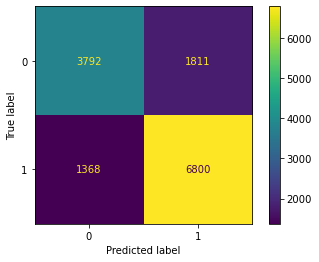

In [14]:
evaluate(clf_logreg, X_train, X_test, y_train, y_test)

Baseline model showed satisfactory results.
I would've liked to have more false negatives than false positives
I will continue to build and test other models using my pipeline, this time with more parameters within each unique
classifier to obtain the best results.

# Decision Tree Model w/ Grid Search

In [15]:
clf_decision_tree = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', DecisionTreeClassifier(random_state=0))])

# I will be using GridSearchCV to determine the best parameters for my classifier.
# First I will set a parameter limit to apply to the 'param_grid'

# To set paramaters for the Decision Tree Classifier, I couldn't use "max_depth" or "min_samples_split"
# as stated in the documentation because there was conflict using a pipeline method as the estimator.
# Therefore I had to use "classifier__" before the standard Decision Tree Classifier parameters.

param_limit = {
    'classifier__max_depth': [3, 5, 10],
    'classifier__min_samples_split': [4, 7],
    'classifier__min_samples_leaf': [2,4],
}


grid_decision_tree = GridSearchCV(clf_decision_tree, param_grid=param_limit)

grid_decision_tree.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'public_meeting',
                                                                          

In [16]:
def get_best_parameters(classifier):
    best_parameters = classifier.best_params_
    
    print('Grid Search found the following optimal parameters:')
    print('-----' * 10)
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

In [17]:
get_best_parameters(grid_decision_tree)

Grid Search found the following optimal parameters:
--------------------------------------------------
classifier__max_depth: 10
classifier__min_samples_leaf: 4
classifier__min_samples_split: 4


Train Scores
------------
Accuracy: 80.24%
F1: 84.43%
ROC-AUC: 77.92%
Precision: 78.11%
Recall: 91.85%
------------------------------
Test Scores
-----------
Accuracy: 79.09%
F1: 83.68%
ROC-AUC: 76.5%
Precision: 77.89%
Recall: 90.4%


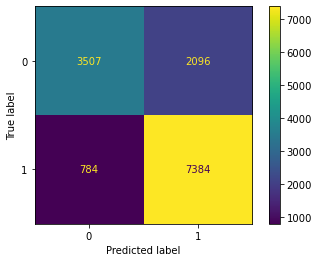

In [18]:
evaluate(grid_decision_tree, X_train, X_test, y_train, y_test)

# K-Nearest Neighbors w/ Grid Search

In [19]:
clf_knn = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', KNeighborsClassifier())])

param_limit = {
    'classifier__n_neighbors': [5, 11, 25],
    'classifier__weights': ['uniform', 'distance'],
}


grid_knn = GridSearchCV(clf_knn, param_grid=param_limit)

grid_knn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'public_meeting',
                                                                          

In [20]:
get_best_parameters(grid_knn)

Grid Search found the following optimal parameters:
--------------------------------------------------
classifier__n_neighbors: 11
classifier__weights: 'uniform'


Train Scores
------------
Accuracy: 84.45%
F1: 87.26%
ROC-AUC: 83.09%
Precision: 83.57%
Recall: 91.29%
------------------------------
Test Scores
-----------
Accuracy: 82.4%
F1: 85.72%
ROC-AUC: 80.87%
Precision: 82.61%
Recall: 89.07%


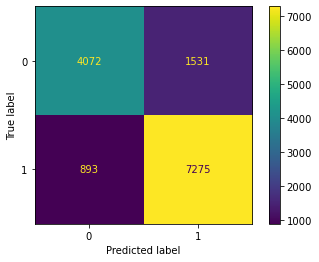

In [21]:
evaluate(grid_knn, X_train, X_test, y_train, y_test)

# Random Forest Model w/ Grid Search

In [22]:
clf_RF= Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=0))])

param_limit = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 3],
}


grid_RF = GridSearchCV(clf_RF, param_grid=param_limit)

grid_RF.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'public_meeting',
                                                                          

In [23]:
get_best_parameters(grid_RF)

Grid Search found the following optimal parameters:
--------------------------------------------------
classifier__criterion: 'entropy'
classifier__max_depth: 15
classifier__min_samples_leaf: 1
classifier__min_samples_split: 2


Train Scores
------------
Accuracy: 87.51%
F1: 90.11%
ROC-AUC: 85.52%
Precision: 83.74%
Recall: 97.51%
------------------------------
Test Scores
-----------
Accuracy: 83.86%
F1: 87.38%
ROC-AUC: 81.5%
Precision: 81.49%
Recall: 94.18%


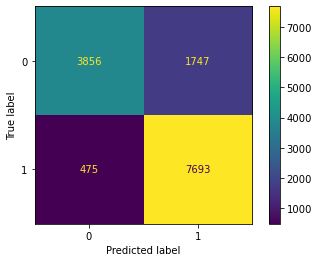

In [24]:
evaluate(grid_RF, X_train, X_test, y_train, y_test)

# XGBoost Model w/ Grid Search

In [25]:
clf_XG = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', XGBClassifier(use_label_encoder=False, disable_default_eval_metric=True))])

param_limit = {
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__max_depth': [15, 20],
    'classifier__gamma': [0,1],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [0.5, 1],
    'classifier__n_estimators': [100]
}


grid_XG = GridSearchCV(clf_XG, param_grid=param_limit)

grid_XG.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'public_meeting',
                                                                          

In [26]:
get_best_parameters(grid_XG)

Grid Search found the following optimal parameters:
--------------------------------------------------
classifier__gamma: 0
classifier__learning_rate: 0.1
classifier__max_depth: 15
classifier__min_child_weight: 2
classifier__n_estimators: 100
classifier__subsample: 1


Train Scores
------------
Accuracy: 92.35%
F1: 93.67%
ROC-AUC: 91.39%
Precision: 90.44%
Recall: 97.15%
------------------------------
Test Scores
-----------
Accuracy: 84.58%
F1: 87.55%
ROC-AUC: 83.03%
Precision: 84.03%
Recall: 91.37%


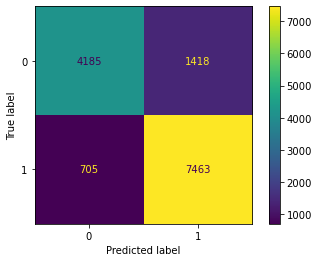

In [27]:
evaluate(grid_XG, X_train, X_test, y_train, y_test)

# SVM (Suport Vector Machine) Model w/ Grid Search

In [28]:
clf_svm = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', SVC(probability=True))])

param_limit = {
    'classifier__C': [10, 12],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': ['scale']
}


grid_svm = GridSearchCV(clf_svm, param_grid=param_limit)

grid_svm.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'public_meeting',
                                                                          

In [29]:
get_best_parameters(grid_svm)

Grid Search found the following optimal parameters:
--------------------------------------------------
classifier__C: 10
classifier__gamma: 'scale'
classifier__kernel: 'rbf'


Train Scores
------------
Accuracy: 92.35%
F1: 93.67%
ROC-AUC: 91.39%
Precision: 90.44%
Recall: 97.15%
------------------------------
Test Scores
-----------
Accuracy: 84.58%
F1: 87.55%
ROC-AUC: 83.03%
Precision: 84.03%
Recall: 91.37%


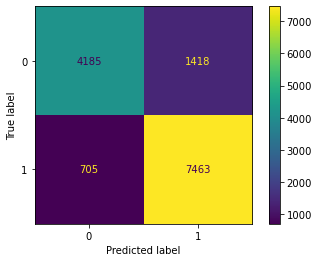

In [30]:
evaluate(grid_XG, X_train, X_test, y_train, y_test)

# Final Model Further Evaluation and Tuning - KNN

### Top performing parameters and results from initial gridsearch knn model:
    

In [31]:
get_best_parameters(grid_knn)

Grid Search found the following optimal parameters:
--------------------------------------------------
classifier__n_neighbors: 11
classifier__weights: 'uniform'


Train Scores
------------
Accuracy: 84.45%
F1: 87.26%
ROC-AUC: 83.09%
Precision: 83.57%
Recall: 91.29%
------------------------------
Test Scores
-----------
Accuracy: 82.4%
F1: 85.72%
ROC-AUC: 80.87%
Precision: 82.61%
Recall: 89.07%


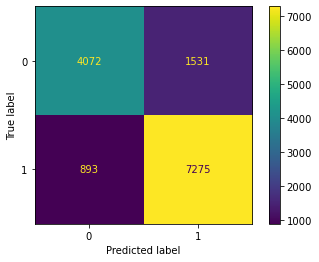

In [32]:
evaluate(grid_knn, X_train, X_test, y_train, y_test)

### First attempt at further hyperparameter tuning:

In [33]:
clf_knn_final_f1 = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', KNeighborsClassifier())])

param_limit = {
    'classifier__n_neighbors': [7, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__leaf_size': [30, 35, 40],
    'classifier__p': [1, 2],
}


grid_knn_final_f1 = GridSearchCV(clf_knn_final_f1, param_grid=param_limit)

grid_knn_final_f1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'public_meeting',
                                                                          

In [34]:
get_best_parameters(grid_knn_final_f1)

Grid Search found the following optimal parameters:
--------------------------------------------------
classifier__leaf_size: 30
classifier__n_neighbors: 7
classifier__p: 1
classifier__weights: 'uniform'


Train Scores
------------
Accuracy: 86.03%
F1: 88.48%
ROC-AUC: 84.84%
Precision: 85.22%
Recall: 91.99%
------------------------------
Test Scores
-----------
Accuracy: 82.76%
F1: 85.94%
ROC-AUC: 81.37%
Precision: 83.21%
Recall: 88.86%


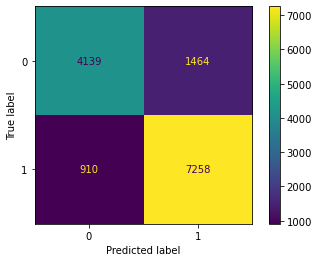

In [35]:
evaluate(grid_knn_final_f1, X_train, X_test, y_train, y_test)

### Second attempt at further hypermarameter tuning:

In [36]:
clf_knn_final_2nd = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', KNeighborsClassifier())])

param_limit = {
    'classifier__n_neighbors': [5, 7, 9],
    'classifier__weights': ['uniform'],
    'classifier__leaf_size': [20, 25, 30],
    'classifier__p': [1, 2],
    'classifier__algorithm': ['ball_tree','kd_tree','brute']
}


grid_knn_final_2nd = GridSearchCV(clf_knn_final_2nd, param_grid=param_limit)

grid_knn_final_2nd.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'public_meeting',
                                                                          

In [37]:
get_best_parameters(grid_knn_final_2nd)

Grid Search found the following optimal parameters:
--------------------------------------------------
classifier__algorithm: 'ball_tree'
classifier__leaf_size: 20
classifier__n_neighbors: 7
classifier__p: 1
classifier__weights: 'uniform'


Train Scores
------------
Accuracy: 86.01%
F1: 88.46%
ROC-AUC: 84.83%
Precision: 85.23%
Recall: 91.95%
------------------------------
Test Scores
-----------
Accuracy: 82.75%
F1: 85.93%
ROC-AUC: 81.36%
Precision: 83.23%
Recall: 88.82%


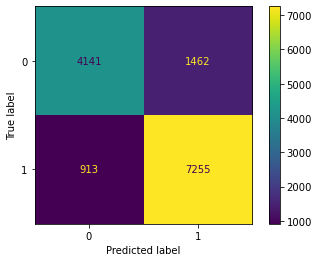

In [38]:
evaluate(grid_knn_final_2nd, X_train, X_test, y_train, y_test)

After two extensive attempts at bettering the KNN model results, I've concluded that my initial KNN parameters show the best results. In this case, the simpler model performs just as well if not better than the more complex hyperparameter tunings with gridsearch. 